In [9]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from main import *
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import datetime, os
from matplotlib import pyplot as plt
from tensorboard.plugins.hparams import api as hp

from pathlib import Path 
import pandas as pd


In [4]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nome gpu:  /device:GPU:0


## Preparazione dati

### Caricamento dataset statici

In [2]:
test=load_file("C:/Users/Francesco/Desktop/datasetPronti/set_test")
train=load_file("C:/Users/Francesco/Desktop/datasetPronti/set_training")
validation=load_file("C:/Users/Francesco/Desktop/datasetPronti/set_validation")
 

File loaded
File loaded
File loaded


In [3]:
test=np.array(test,dtype=np.int8)
train=np.array(train,dtype=np.int8)
validation=np.array(validation,dtype=np.int8)

## Modello

In [ ]:
# TODO: Cercare come migliorare l'autoencoder e come interpretare le metriche, 
# i test per il momento sono abbastanza a meno che non vuoi provare qualcosa di specifico sulla base di qello che trovi

#****************************************************************************************************

logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]

#Cose da fare per migliorare la rete solo dopo aver fatto i primi tentativi con la rete proposta:
# * Provare ad aggiungere Regolarizzazione es. L1,L2 e dropout(solo nella fase di encoding)
# * Provare swish al posto di relu
# * Provare tf.keras.layers.BatchNormalization()(var_layer) 
# * Fare Hyperparameter Tuning  (ultima) www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

#PARAM:
#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : 340,
"HIDDEN_SIZE" : 170,
"HIDDEN_SIZE2" : None,
"CODE_SIZE" : 34,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=1e-5),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=0.001),
"EPOCHS":1000,
"BATCH_SIZE":5000}


input_layer = Input(shape=(param["INPUT_SIZE"],))
x = Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] )(input_layer)
#x = Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"] )(x)

code = Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"])(x)
#x =Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"])(code)
x =Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"])(x)

output_layer = Dense(param["INPUT_SIZE"], activation='sigmoid')(x)

autoencoder = Model(input_layer, output_layer)
#variare learning_rate beta_1,beta_2, da fare per ultimo
#batch_size ???
autoencoder.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoder.fit(x=train,y=train, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(validation,validation), callbacks=my_callbacks,
                      )

 #Gardare i risulati delle metriche su tensorbord                      

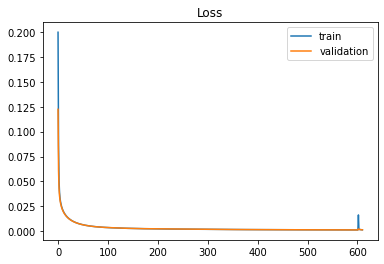

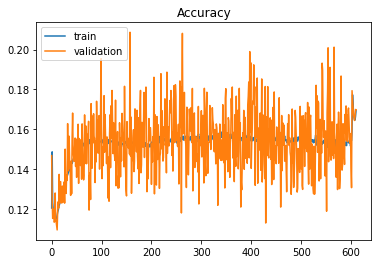

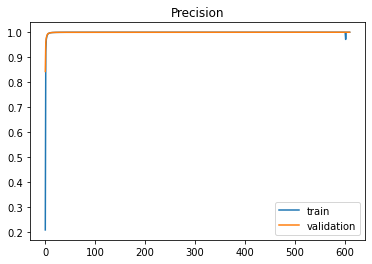

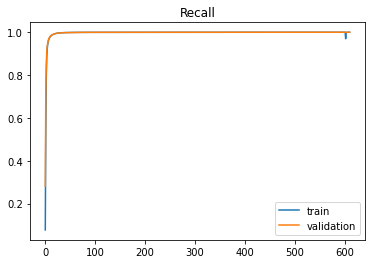

In [25]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()




In [23]:
val_predictions = autoencoder.predict(validation)
test_predictions = autoencoder.predict(test)

7211/7211 [==============================] - 8s 1ms/step


Numero di vettori decodificati correttamente: 230203 su 230728 totali 
Rapporto: 99.772% 
Media num di errori per array: 0.003



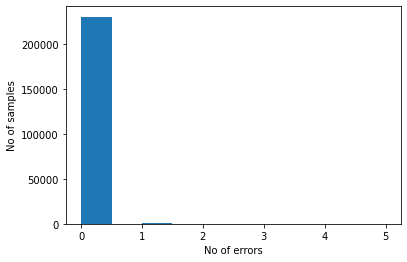

csv not created


<Figure size 432x288 with 0 Axes>

In [24]:
arr=results_info(test,test_predictions,logdir,param) 

In [10]:
#%tensorboard --logdir logsTf
%load_ext tensorboard
#Avvio da terminale: spostarsi nella cartella dove è presente la cartella di log, > tensorboard --logdir nomecartella

In [ ]:
autoencoder.summary()